## 🔎 Exploring Advanced Models for COVID-19 Mortality


Building on our initial multiple linear regression (MLR) analysis, this notebook employs more advanced modeling techniques to better understand the relationship between long-term PM₂.₅ exposure, socio-demographic development (SDI), and COVID-19 mortality across countries. We leverage machine learning methods (Random Forest), nonlinear modeling (splines), interaction analysis, quantile regression, and influential data point detection to capture complex and context-dependent effects. These approaches go beyond traditional linear models, allowing us to uncover nuanced patterns and provide deeper insight into the factors shaping COVID-19 mortality at the country level.


### 📦 Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from patsy import dmatrix
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.regression.quantile_regression as qr

### 📁 Dataset Read & Preview

In [19]:
df = pd.read_csv("../1_datasets/final_datasets/final_merged_covid_sdi_pm2.5.csv")
df.head()

,Country,COVID_Deaths_Rate,upper,lower,Mean_PM25_2010_2019,Year,SDI_mean_value
0,Spain,5.413404e+01,5.658407e+01,5.143939e+01,10.995,2020,0.766506
1,Belgium,7.419978e+01,7.682945e+01,7.168123e+01,13.595,2020,0.851347
2,Samoa,3.247490e-09,3.247490e-09,3.247490e-09,7.623,2020,0.590075
3,Papua New Guinea,2.144257e+01,4.769251e+01,3.794842e+00,8.645,2020,0.415187
4,Republic of Moldova,6.889802e+01,8.799219e+01,4.823898e+01,14.186,2020,0.727711


### 🌳 Random Forest Regression for COVID-19 Mortality

We use a Random Forest model to predict the (log-transformed) COVID-19 death rate based on long-term PM₂.₅ exposure and SDI. 

We fit a Random Forest regression model to predict age-standardized COVID-19 death rates using long-term PM₂.₅ exposure and SDI as predictors. This approach allows us to capture potential nonlinear and interactive effects between these variables. 

The model is trained with 100 trees and default hyperparameters, using a 70/30 train-test split.


In [28]:
X = df[["Mean_PM25_2010_2019", "SDI_mean_value"]]
y = df["COVID_Deaths_Rate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 📊 Model Evaluation

We evaluated the Random Forest model’s performance on the test set using R², MAE, and RMSE metrics:

- **R² = 0.24**: The model explains about 24% of the variance in age-standardized COVID-19 death rates.  
- **MAE = 61.5**, **RMSE = 84.2**: The prediction errors indicate moderate accuracy, suggesting that other unmeasured factors likely influence COVID-19 mortality across countries.


In [29]:
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Performance on Test Set:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

Model Performance on Test Set:
R²: 0.236
MAE: 61.483
RMSE: 84.227


### ⭐ Feature Importance

The Random Forest model indicates that both long-term PM₂.₅ exposure and SDI contribute to predicting age-standardized COVID-19 mortality. 

In this analysis, **SDI shows slightly higher importance (55%)** compared to **PM₂.₅ (45%)**. This suggests that while both factors are relevant, socio-demographic development may play a somewhat larger role in explaining cross-country differences in COVID-19 death rates.


In [30]:
importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

print("Feature Importance:")
print(importance)

Feature Importance:
               Feature  Importance
1       SDI_mean_value    0.553802
0  Mean_PM25_2010_2019    0.446198


### 📉 Partial Dependence Plots

The partial dependence plots illustrate how predicted age-standardized COVID-19 mortality changes with PM₂.₅ exposure and SDI, while holding the other variable constant. 

Both predictors show **nonlinear relationships** with mortality, including **sharp changes at certain values**. This demonstrates the advantage of using a flexible model like Random Forest, which can capture complex and non-linear effects that simpler models might miss.


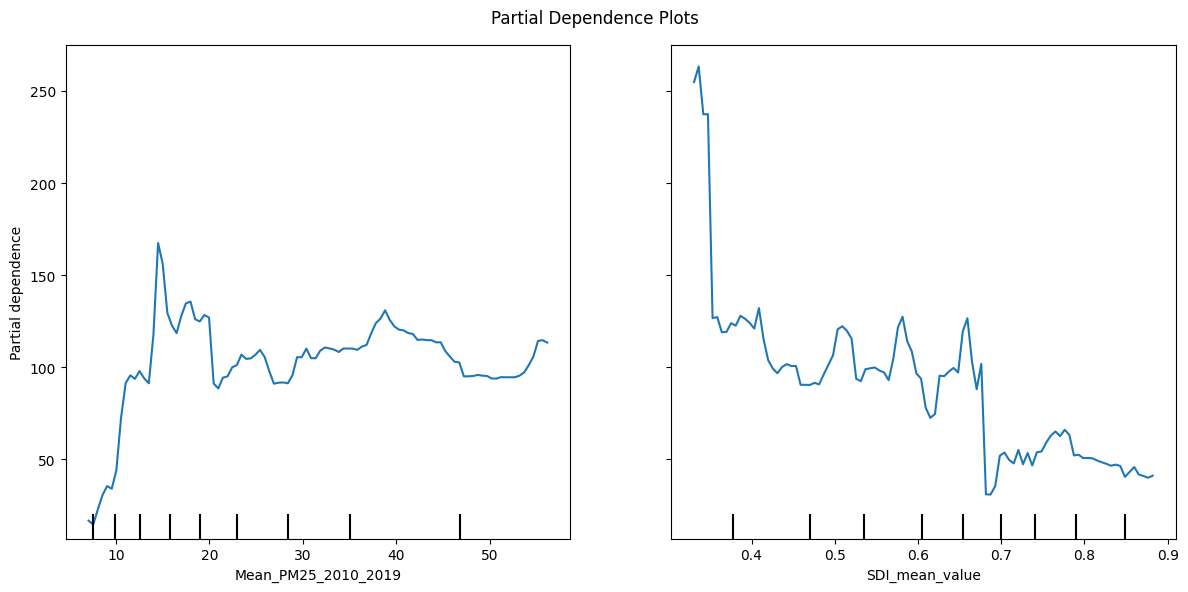

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf, X_train, ["Mean_PM25_2010_2019", "SDI_mean_value"], ax=ax
)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()

### 📈 Spline Regression for Nonlinear Effects

To capture potential nonlinear effects of PM₂.₅ on age-standardized COVID-19 mortality, we fit an OLS regression using spline terms for PM₂.₅ and included SDI as a covariate.

- **Model Fit**: The model explains about 35% of the variance in COVID-19 death rates (**R² = 0.35**).
- **Findings**: Several spline terms for PM₂.₅ are statistically significant, indicating a nonlinear association. SDI shows a strong negative effect, suggesting that higher socio-demographic development is associated with lower COVID-19 mortality.
- **Interpretation**: This approach highlights that the relationship between PM₂.₅ and COVID-19 mortality is not strictly linear, and both air pollution and SDI play important roles in explaining cross-country differences.


In [33]:
pm25_spline = dmatrix(
    "bs(Mean_PM25_2010_2019, df=4, include_intercept=False)",
    {"Mean_PM25_2010_2019": df["Mean_PM25_2010_2019"]},
    return_type="dataframe",
)

X = pd.concat([pm25_spline, df["SDI_mean_value"]], axis=1)
X = sm.add_constant(X)
y = df["COVID_Deaths_Rate"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      COVID_Deaths_Rate   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     20.00
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           6.60e-16
Time:                        16:09:58   Log-Likelihood:                -1087.1
No. Observations:                 190   AIC:                             2186.
Df Residuals:                     184   BIC:                             2206.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

### 📊 Visualizing the Nonlinear Effect of PM₂.₅

This plot shows the predicted relationship between long-term PM₂.₅ exposure and the age-standardized COVID-19 death rate, with uncertainty bands from the spline regression. 

The curve highlights a **nonlinear association**: COVID-19 mortality risk **increases with PM₂.₅ up to a certain level**, then **flattens**, and **rises again at higher concentrations**. 

The scatter points represent actual country data, illustrating both the model fit and the variability in observed outcomes.


X_pred columns: Index(['Intercept', 'bs(x, df=4, include_intercept=False)[0]',
       'bs(x, df=4, include_intercept=False)[1]',
       'bs(x, df=4, include_intercept=False)[2]',
       'bs(x, df=4, include_intercept=False)[3]', 'SDI_mean_value'],
      dtype='object')
Model params: Index(['Intercept',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[0]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[1]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[2]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[3]',
       'SDI_mean_value'],
      dtype='object')


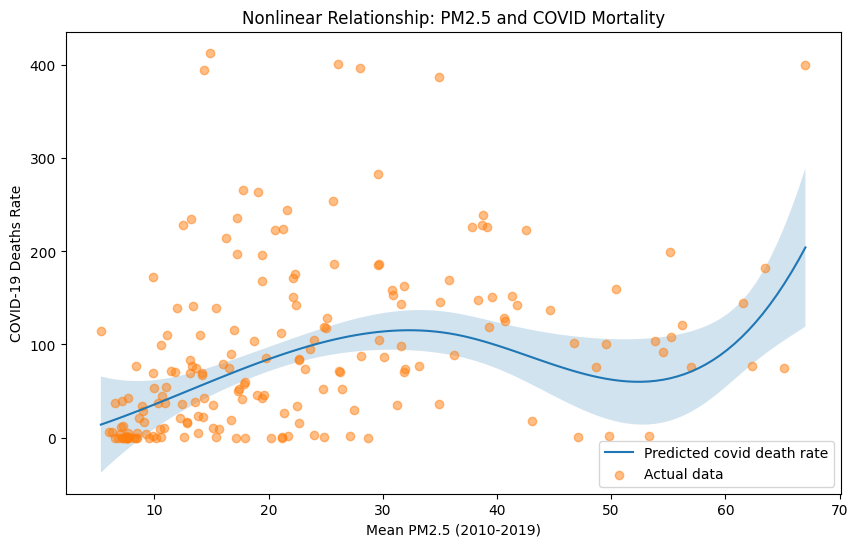

In [37]:
pm25_range = np.linspace(
    df["Mean_PM25_2010_2019"].min(), df["Mean_PM25_2010_2019"].max(), 100
)
pm25_spline = dmatrix(
    "bs(x, df=4, include_intercept=False)", {"x": pm25_range}, return_type="dataframe"
)

X_pred = pd.concat(
    [
        pm25_spline.reset_index(drop=True),
        pd.DataFrame(
            {"SDI_mean_value": df["SDI_mean_value"].median()}, index=range(100)
        ),
    ],
    axis=1,
)

print("X_pred columns:", X_pred.columns)
print("Model params:", model.params.index)

pred = model.get_prediction(X_pred)
pred_summary = pred.summary_frame(alpha=0.05)

pred_df = pd.DataFrame(
    {
        "PM25": pm25_range,
        "Predicted": pred_summary["mean"],
        "CI_low": pred_summary["mean_ci_lower"],
        "CI_high": pred_summary["mean_ci_upper"],
    }
)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(pred_df["PM25"], pred_df["Predicted"], label="Predicted covid death rate")
plt.fill_between(pred_df["PM25"], pred_df["CI_low"], pred_df["CI_high"], alpha=0.2)
plt.scatter(
    df["Mean_PM25_2010_2019"], df["COVID_Deaths_Rate"], alpha=0.5, label="Actual data"
)
plt.xlabel("Mean PM2.5 (2010-2019)")
plt.ylabel("COVID-19 Deaths Rate")
plt.title("Nonlinear Relationship: PM2.5 and COVID Mortality")
plt.legend()
plt.show()

### 🔄 Modeling Interaction: PM₂.₅ and SDI

We extended the spline regression to include an interaction between PM₂.₅ and SDI. This model explains about 40% of the variance in age-standardized COVID-19 death rates (**R² = 0.40**).

- **Findings**: Several interaction terms are statistically significant, indicating that the effect of PM₂.₅ on COVID-19 mortality varies by SDI level.
- **Interpretation**: The relationship between air pollution and COVID-19 mortality is not only **nonlinear**, but also **depends on a country’s socio-demographic development**. This highlights the importance of considering both environmental and social factors together when analyzing global health outcomes.


In [38]:
formula = """
COVID_Deaths_Rate ~ 
bs(Mean_PM25_2010_2019, df=4) * SDI_mean_value
"""
interaction_model = smf.ols(formula, data=df).fit()
print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:      COVID_Deaths_Rate   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     13.55
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           1.72e-16
Time:                        16:25:05   Log-Likelihood:                -1079.1
No. Observations:                 190   AIC:                             2178.
Df Residuals:                     180   BIC:                             2211.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### PM₂.₅ vs COVID-19 Mortality by SDI Category

This plot shows the relationship between average PM₂.₅ levels (2010–2019) and age-standardized COVID-19 death rates across countries, grouped by SDI level:

- Each point represents a country.  
- The lines show **smoothed (nonlinear) trends** within each SDI group.

**Highlights:**

- **Low SDI**: Mortality rates tend to increase with higher PM₂.₅ exposure.  
- **Medium SDI**: The trend is relatively flat, with some increase at higher PM₂.₅ levels.  
- **High SDI**: Shows a nonlinear pattern, with mortality peaking at mid-range PM₂.₅.  
- **Very High SDI**: Mortality rates are generally lower and less sensitive to PM₂.₅ changes.

These patterns suggest that the **association between air pollution and COVID-19 mortality varies by socio-demographic development**, possibly reflecting differences in healthcare capacity, population structure, and pandemic response.


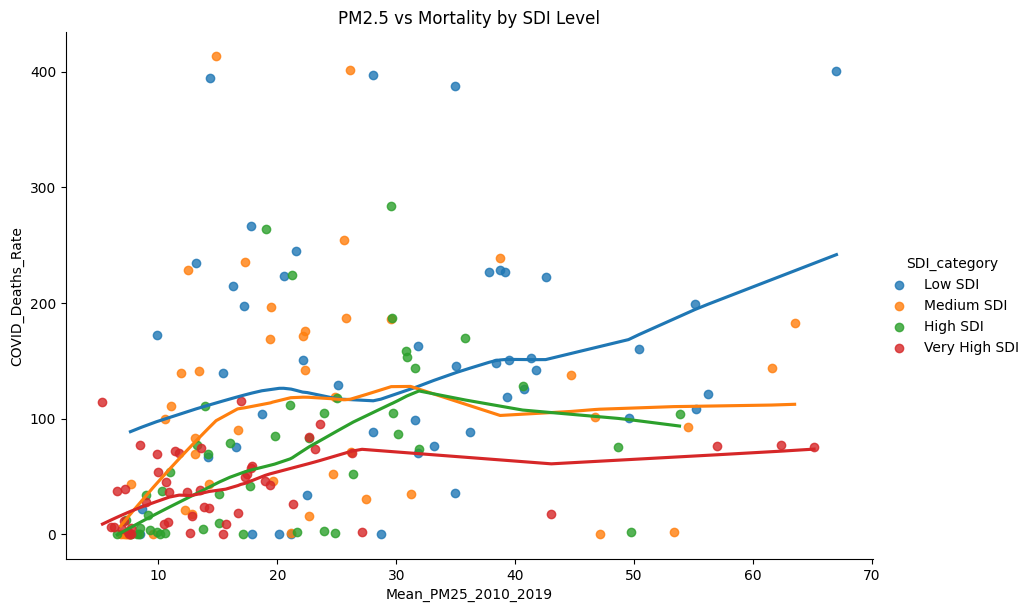

In [40]:
df["SDI_category"] = pd.qcut(
    df["SDI_mean_value"],
    4,
    labels=["Low SDI", "Medium SDI", "High SDI", "Very High SDI"],
)

sns.lmplot(
    x="Mean_PM25_2010_2019",
    y="COVID_Deaths_Rate",
    hue="SDI_category",
    data=df,
    ci=None,
    height=6,
    aspect=1.5,
    lowess=True,  # <--- nonlinear fit
)
plt.title("PM2.5 vs Mortality by SDI Level")
plt.show()

### 🔍 Identifying Influential Data Points

We used **Cook’s distance** to identify the most influential countries in the regression analysis. 

The top five influential points include countries with extreme values in COVID-19 death rates, PM₂.₅ exposure, or SDI (e.g., **Central African Republic, Eswatini, Bahamas, Somalia, Afghanistan**).

These outliers may disproportionately affect model results and **warrant further investigation or sensitivity analysis** to ensure robust conclusions.


In [41]:
infl = OLSInfluence(model)
print("\nTop 5 Influential Points:")

top5_idx = infl.cooks_distance[0].argsort()[-5:]

print(
    df.loc[
        top5_idx,
        ["Country", "COVID_Deaths_Rate", "Mean_PM25_2010_2019", "SDI_mean_value"],
    ]
)


Top 5 Influential Points:
                      Country  COVID_Deaths_Rate  Mean_PM25_2010_2019  \
125  Central African Republic         397.160610               28.013   
71                   Eswatini         413.522160               14.859   
109                   Bahamas         114.545886                5.306   
115                   Somalia         394.429938               14.380   
43                Afghanistan         400.853389               67.013   

     SDI_mean_value  
125        0.305426  
71         0.581653  
109        0.802948  
115        0.076363  
43         0.329830  


### Quantile Regression Analysis

To explore how predictors affect different parts of the COVID-19 mortality distribution, we ran quantile regressions at the 25th, 50th, and 75th percentiles.

**Findings:**

- At the **25th percentile**, higher PM₂.₅ is significantly associated with increased COVID-19 mortality, and SDI is also significantly negative.  
- At the **median (50th percentile)**, the association between PM₂.₅ and mortality is weaker and not statistically significant, while SDI remains strongly negative.  
- At **higher quantiles** (not shown), the patterns may differ further.

This suggests that **PM₂.₅ has a stronger effect in countries with lower COVID-19 mortality rates**, while SDI consistently shows a protective effect, especially at the median. Quantile regression provides a more nuanced view than mean-based models, revealing that the impact of air pollution and socio-demographic factors can differ across the mortality distribution.


In [43]:
for quantile in [0.25, 0.5, 0.75]:
    q_model = qr.QuantReg(
        df["COVID_Deaths_Rate"],
        sm.add_constant(df[["Mean_PM25_2010_2019", "SDI_mean_value"]]),
    ).fit(q=quantile)
    print(f"\nQuantile {quantile} Results:")
    print(q_model.summary())


Quantile 0.25 Results:
                         QuantReg Regression Results                          
Dep. Variable:      COVID_Deaths_Rate   Pseudo R-squared:               0.1324
Model:                       QuantReg   Bandwidth:                       48.67
Method:                 Least Squares   Sparsity:                        155.1
Date:                Thu, 17 Jul 2025   No. Observations:                  190
Time:                        16:30:43   Df Residuals:                      187
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  38.3304     27.203      1.409      0.160     -15.334      91.995
Mean_PM25_2010_2019     1.7873      0.447      3.997      0.000       0.905       2.670
SDI_mean_value        -69.1647     30.112     -2.297      0.023    -128

## Discussion & Conclusion

In this notebook, we used statistical and machine learning models to explore how long-term PM₂.₅ exposure and socio-demographic development (SDI) relate to age-standardized COVID-19 mortality across countries.

### Key Insights

**Random Forest Modeling**  
Both PM₂.₅ and SDI emerged as important predictors of age-standardized COVID-19 mortality, with SDI showing slightly higher importance in the updated analysis. The model explained about 24% of the variance, indicating that while these factors are relevant, other unmeasured variables also play a substantial role.

**Nonlinear and Interaction Effects**  
Spline regression revealed a nonlinear relationship between PM₂.₅ and mortality, with risk increasing up to a point, flattening, and then rising again at higher concentrations. Interaction models further showed that the impact of air pollution on mortality varies by SDI level, with the best models explaining up to 40% of the variance.

**Influential Data Points**  
Countries with extreme values in mortality, PM₂.₅, or SDI (such as Central African Republic, Eswatini, Bahamas, Somalia, and Afghanistan) had a noticeable influence on the models. This emphasizes the importance of cautious interpretation and the need for sensitivity analyses.

**Quantile Regression**  
The association between PM₂.₅ and COVID-19 mortality was strongest at lower quantiles, while SDI consistently showed a protective effect, especially at the median. This suggests that air pollution may matter more in countries with relatively lower death rates, and that the impact of socio-demographic development is robust across the mortality distribution.

### Limitations and Context

- The analysis does **not** include key factors such as healthcare capacity, age distribution, comorbidities, or policy responses.  
- Early waves of COVID-19 heavily affected higher-SDI countries, which may confound the observed relationships.  
- Differences in testing, reporting, and pandemic timing across countries add complexity to the analysis.  
- Using country-level data may overlook significant within-country variation and local dynamics.

### Conclusion

This analysis demonstrates that long-term air pollution and socio-demographic development are linked to age-standardized COVID-19 mortality in **complex, nonlinear, and context-dependent ways**. While our models highlight these associations and explain a moderate share of the variance, results must be interpreted in light of unmeasured confounders and the unique dynamics of the pandemic.

These findings underscore the importance of considering both environmental and social factors, as well as the need for more granular data and further research to fully understand the drivers of COVID-19 mortality across countries.
